In [953]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import matplotlib.pyplot as plt
import h5py
import random
import jax.numpy as jnp

garstec_data = 'C:\\Users\\Dell\\Downloads\\Garstec_AS09_chiara.hdf5'

sun_numax = 3090

In [954]:
# Initialize lists to store the mean values from each track
ages = []
massini = []
fehini = []

# Open the hdf5 file (read-only mode)
with h5py.File(garstec_data, 'r') as hdf:
    grid = hdf['grid']
    tracks = grid['tracks']

    # Get a list of track names (optionally shuffle for random sampling)
    track_names = list(tracks.keys())
    random.seed(1)
    random.shuffle(track_names)

    # Choose a subset of tracks to process
    num_tracks = 4000  # Set the number of tracks to process
    selected_tracks = track_names[:num_tracks]

    # Iterate over the selected track names
    for track_name in selected_tracks:
        track = tracks[track_name]
        
        # Compute the mean of each parameter for the current track
        ages.append(np.mean(track['age'][:]))
        massini.append(np.mean(track['massini'][:]))
        fehini.append(np.mean(track['FeHini'][:]))

In [955]:
def model():
    # Sample initial mass from Beta distribution and transform
    massini = numpyro.deterministic("massini", 
                                  0.8 * numpyro.sample("massini_s", dist.Beta(2.25, 1.5)) + 0.7)
    
    # Sample tau parameter from Beta distribution and transform
    tau_hat = numpyro.deterministic("tau_hat", 
                                   8 * numpyro.sample("tau_hat_s", dist.Beta(1.25, 2)) + 1) 
    
    fehini = numpyro.deterministic("fehini", 0.95 * numpyro.sample("fehini_s", dist.Beta(10, 1)))
    
    # Calculate intermediate tau value
    tau_ms = (3000) * (massini**-3.15)
    
    # Calculate final age
    #age = numpyro.deterministic("Age", tau_hat * tau_ms)

    age = numpyro.deterministic("Age", jnp.minimum(tau_hat * tau_ms, 20000))

    tau_feh = 7 * jnp.log10(massini) + 1 * jnp.log10(age/(2*10**3)) - 1.75

    feh = numpyro.deterministic("feh", tau_feh * fehini)
    
    
    return age



In [956]:
from jax import random

nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key)

posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 2000/2000 [00:02<00:00, 716.84it/s, 7 steps of size 5.25e-01. acc. prob=0.95] 


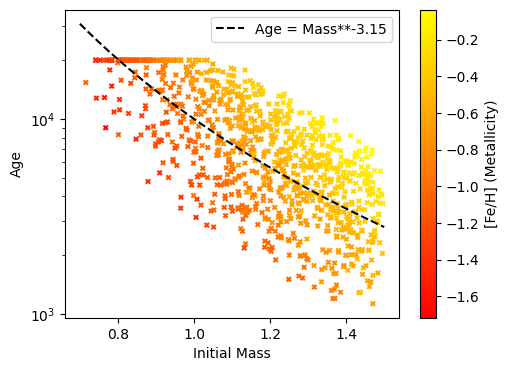

In [957]:
import arviz as az

trace = az.from_numpyro(mcmc)

ages_samples = trace.posterior['Age'].values.flatten()
mass_samples = trace.posterior['massini'].values.flatten()
fehini_samples = trace.posterior['feh'].values.flatten()

x = np.linspace(0.7, 1.5, 100)
tau = (10000) * (x**-3.15)

plt.figure(figsize=(5.4, 4))

# Scatter plot with fehini_samples mapped to color
sc = plt.scatter(mass_samples, ages_samples, c=fehini_samples, cmap='autumn', marker='x', s=10)

plt.yscale('log')  # Log scale for y-axis
plt.xlabel("Initial Mass")
plt.ylabel("Age")

# Add a colorbar to show fehini values
cbar = plt.colorbar(sc)
cbar.set_label("[Fe/H] (Metallicity)")

plt.plot(x, tau, 'k', label='Age = Mass**-3.15', ls='--')

plt.legend()
plt.show()



C:\Users\Dell\AppData\Local\Temp\ipykernel_60056\2051101983.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


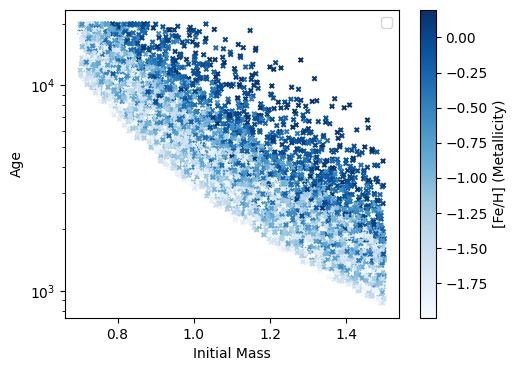

In [958]:
plt.figure(figsize=(5.4, 4))

# Scatter plot with fehini_samples mapped to color
sc_g = plt.scatter(massini, ages, c=fehini, cmap='Blues', marker='x', s=10)

plt.yscale('log')  # Log scale for y-axis
plt.xlabel("Initial Mass")
plt.ylabel("Age")

# Add a colorbar to show fehini values
cbar = plt.colorbar(sc_g)
cbar.set_label("[Fe/H] (Metallicity)")

plt.legend()
plt.show()

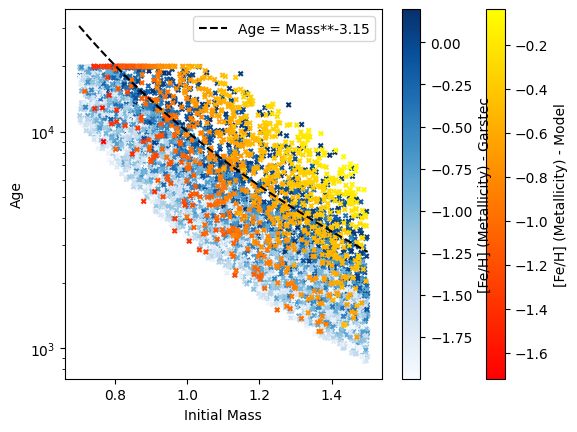

In [959]:
sc = plt.scatter(mass_samples, ages_samples, c=fehini_samples, cmap='autumn', marker='x', s=10, zorder=2)

sc_g = plt.scatter(massini, ages, c=fehini, cmap='Blues', marker='x', s=10, zorder=1)

plt.yscale('log')  # Log scale for y-axis
plt.xlabel("Initial Mass")
plt.ylabel("Age")

# Add a colorbar to show fehini values
cbar = plt.colorbar(sc)
cbar.set_label("[Fe/H] (Metallicity) - Model")

cbar = plt.colorbar(sc_g)
cbar.set_label("[Fe/H] (Metallicity) - Garstec")

plt.plot(x, tau, 'k', label='Age = Mass**-3.15', ls='--')

plt.legend()
plt.show()

In [ ]:
print(np.mean(fehini))
print(np.mean(fehini_samples))
print(min(fehini_samples))

-0.9506041626793132
-0.6611294
-1.7174189


: 